Files already downloaded and verified
Files already downloaded and verified


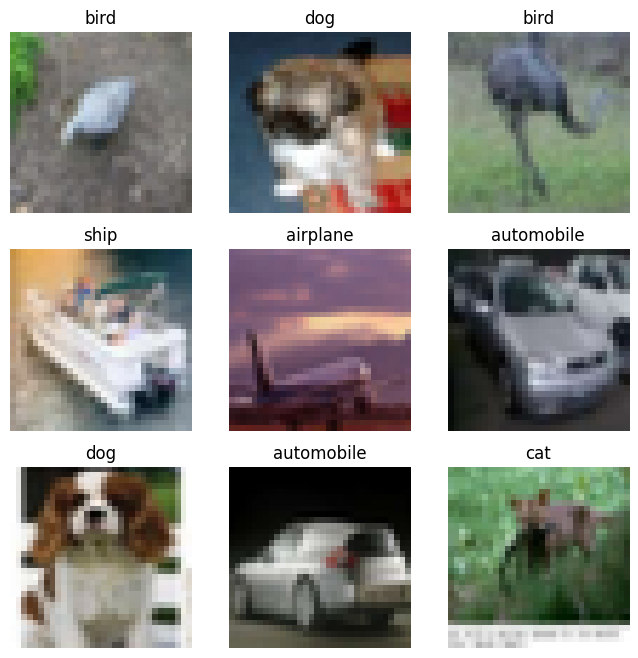

Epoch [1/5], Loss: 1.6766, Train Acc: 40.22%, Val Acc: 46.12%
Epoch [2/5], Loss: 1.4962, Train Acc: 46.96%, Val Acc: 48.66%
Epoch [3/5], Loss: 1.4138, Train Acc: 49.81%, Val Acc: 50.60%
Epoch [4/5], Loss: 1.3569, Train Acc: 51.72%, Val Acc: 52.24%
Epoch [5/5], Loss: 1.3100, Train Acc: 53.59%, Val Acc: 52.58%


<ipython-input-11-94bdacadcadc>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Accuracy: 52.16%


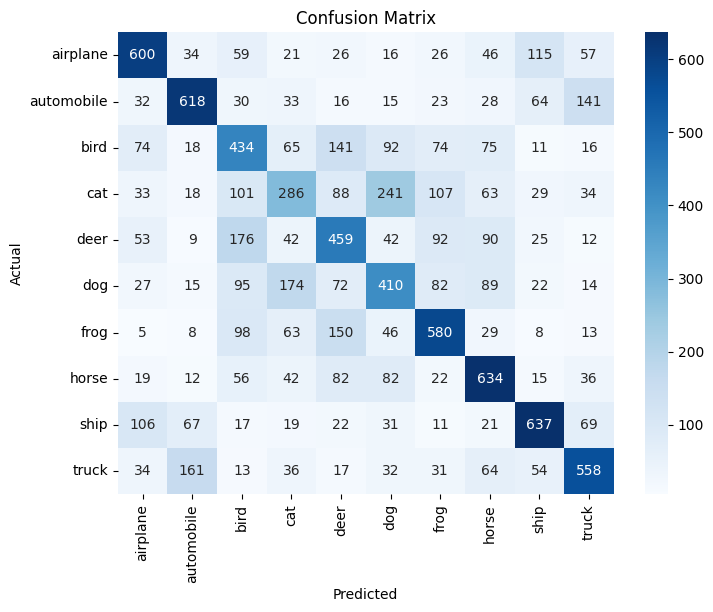

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

batch_size = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = trainset.dataset.classes

def plot_samples(dataset):
    figure = plt.figure(figsize=(8, 8))
    for i in range(9):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(classes[label])
        plt.axis("off")
    plt.show()

plot_samples(trainset)

class FeedforwardNN(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_layers=[128, 64], output_size=10, activation_fn='relu'):
        super(FeedforwardNN, self).__init__()
        layers = []
        in_features = input_size

        for h in hidden_layers:
            layers.append(nn.Linear(in_features, h))
            if activation_fn == 'relu':
                layers.append(nn.ReLU())
            elif activation_fn == 'sigmoid':
                layers.append(nn.Sigmoid())
            layers.append(nn.BatchNorm1d(h))
            in_features = h

        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


def train_model(model, trainloader, valloader, optimizer, criterion, epochs=10, device='cpu'):
    model.to(device)
    best_val_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, valloader, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return best_val_acc

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


def get_optimizer(model, optimizer_name, learning_rate=0.001):
    if optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'momentum':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'nesterov':
        return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer_name == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'nadam':
        return optim.NAdam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_layers = [128, 64]
learning_rate = 0.001
optimizer_name = 'adam'

model = FeedforwardNN(hidden_layers=hidden_layers).to(device)
optimizer = get_optimizer(model, optimizer_name, learning_rate)
criterion = nn.CrossEntropyLoss()

best_val_acc = train_model(model, trainloader, valloader, optimizer, criterion, epochs=5, device=device)


model.load_state_dict(torch.load('best_model.pth'))
test_acc = evaluate_model(model, testloader, device)
print(f"Test Accuracy: {test_acc:.2f}%")

def plot_confusion_matrix(model, dataloader, classes, device='cpu'):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, testloader, classes, device)
